<a href="https://colab.research.google.com/github/shyamjith94/PyTorch/blob/main/CIFAR_10_DataSet_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
%%capture
!pip install torch torchvision

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch, torchvision
import torch.nn as NN
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from torchvision.utils import make_grid

In [44]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [45]:
transform = transforms.ToTensor()

In [46]:
train_data = datasets.CIFAR10(root="/content/drive/MyDrive/PyTorch/Data/Cifar", train=True, download=True, transform=transform)

Files already downloaded and verified


In [47]:
test_data = datasets.CIFAR10(root="/content/drive/MyDrive/PyTorch/Data/Cifar", train=False, download=True, transform=transform)

Files already downloaded and verified


In [48]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/PyTorch/Data/Cifar
    Split: Train
    StandardTransform
Transform: ToTensor()

In [49]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/PyTorch/Data/Cifar
    Split: Test
    StandardTransform
Transform: ToTensor()

In [50]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

In [51]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [52]:
for image, label in train_loader:
    break

tensor([9, 5, 2, 3, 0, 5, 9, 5, 1, 6])
['truck', 'dog', 'bird', 'cat', 'plane', 'dog', 'truck', 'dog', 'car', 'frog']


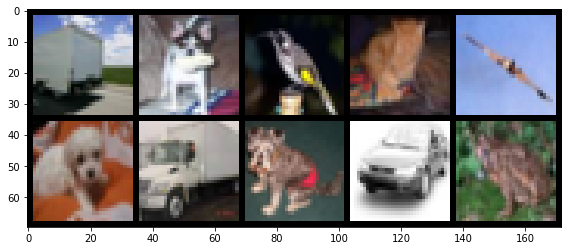

In [53]:
im = make_grid(image, nrow=5)

plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
print(label)
names = [class_names[i] for i in label]
print(names)

In [54]:
class ConvolutionalNetwork(NN.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = NN.Conv2d(3, 6, 5, 1) # (3 input chanel rgb image 6 kernal size 5 filter)
        self.conv2 = NN.Conv2d(6, 16, 3, 1)
        self.fc1 = NN.Linear(6*6*16, 120) # (6*6*16)
        self.fc2 = NN.Linear(120, 84)
        self.fc3 = NN.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [55]:
image[0].shape
# 3 - color chanel 
# 32 by 32 image 

torch.Size([3, 32, 32])

In [56]:
# -2 is loosing borders
# /2 going to pooling
(((32-2)/2)-2)/2

6.5

In [57]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [58]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [59]:
criterion = NN.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [60]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 1.48408771  accuracy:  20.450%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 1.91546249  accuracy:  26.633%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 2.15578675  accuracy:  30.306%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 1.46141136  accuracy:  32.654%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 1.12712502  accuracy:  34.427%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 2.37179232  accuracy:  35.797%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 1.96842730  accuracy:  37.052%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 1.82864976  accuracy:  37.935%
epoch:  1  batch:  600 [  6000/60000]  loss: 1.22286105  accuracy:  47.300%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 1.33706880  accuracy:  47.233%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 1.11370564  accuracy:  47.411%
epoch:  1  batch: 2400 [ 24000/60000]  loss: 0.99859619  accuracy:  47.913%
epoch:  1  batch: 3000 [ 30000/60000]  loss: 1.20949996  accuracy:  48.483%
epoch:  1  b

In [61]:
torch.save(model.state_dict(), "MyCifarModel.pt")

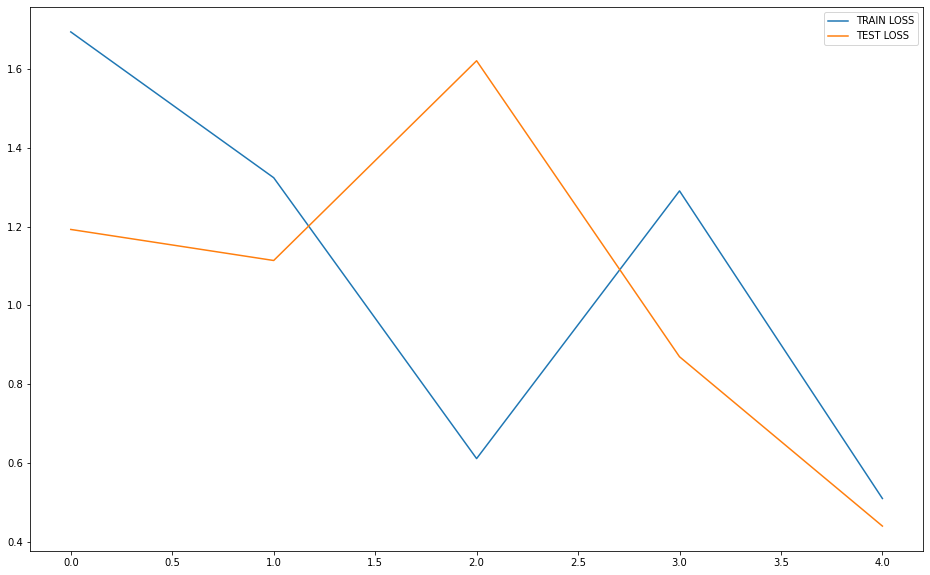

In [62]:
plt.figure(figsize=(16,10))
plt.plot(train_losses, label="TRAIN LOSS")
plt.plot(test_losses, label="TEST LOSS")
plt.legend()

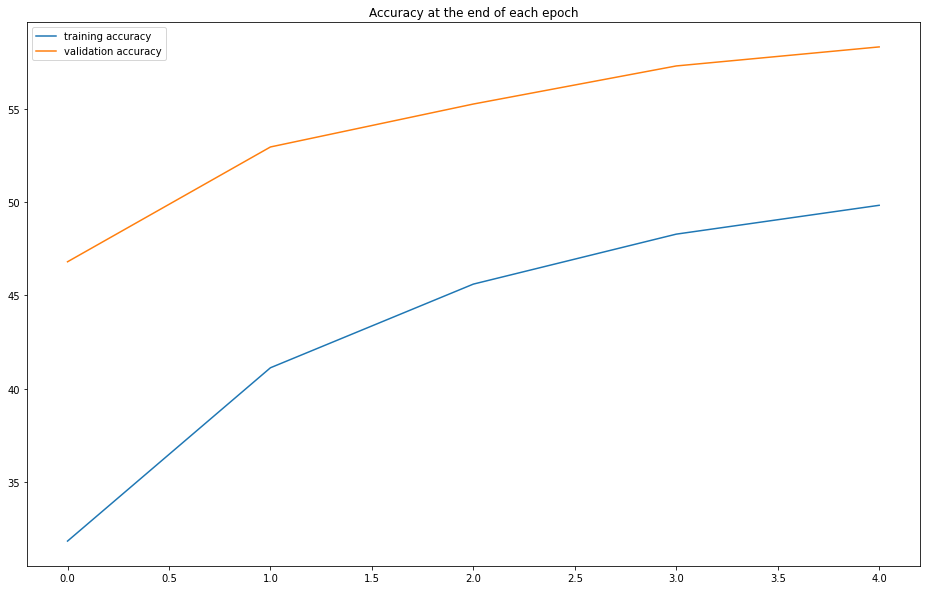

In [63]:
# 600 100 are batch
plt.figure(figsize=(16,10))
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [64]:
test_correct

[tensor(4679), tensor(5294), tensor(5524), tensor(5728), tensor(5830)]

In [65]:
test_c = test_correct[-1].item()

In [66]:
test_c * 100/ 10000

58.3

In [70]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for x_test, y_test in test_load_all:
        y_val  = model(x_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

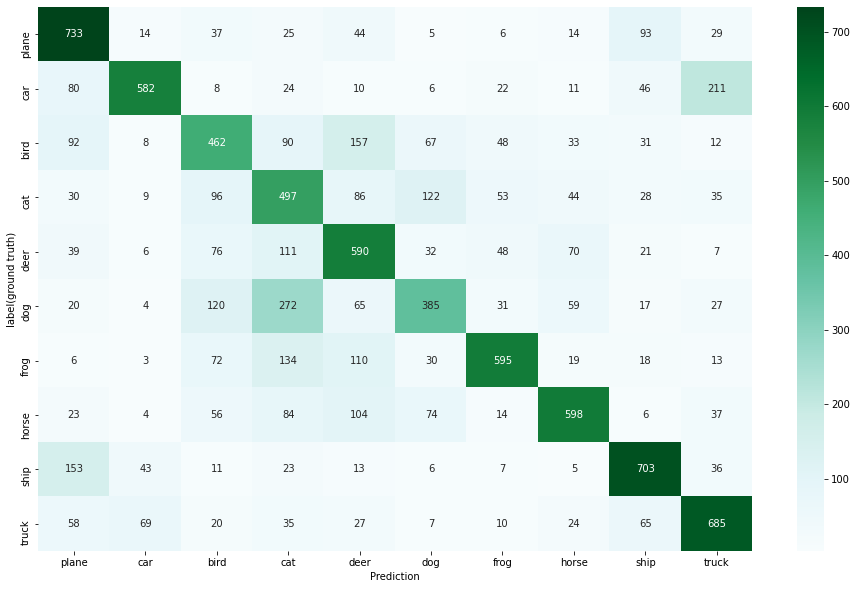

In [73]:
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize=(16, 10))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='BuGn')
plt.xlabel('Prediction')
plt.ylabel('label(ground truth)')
plt.show()